# Hosting Detectron2 model on Sagemaker Inference endpoint

In this notebook we'll package previously trained model into PyTorch Serving container and deploy it on Sagemaker. First, let's review serving container. There are two key difference comparing to training container:
- we are using different base container provided by Sagemaker;
- we need to start Web server (refer to ENTRYPOINT command).

## Compiling Serving Container

In [1]:
! pygmentize -l docker Dockerfile.serving

# # Build an image of Detectron2 with Sagemaker Multi Model Server: https://github.com/awslabs/multi-model-server

# # using Sagemaker PyTorch container as base image
# # from https://github.com/aws/sagemaker-pytorch-serving-container/
# ARG REGION=us-east-1

# FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference-graviton:2.3.0-cpu-py311-ubuntu20.04-sagemaker
# LABEL author="smaraba@ncsu.edu"

# ############# Installing latest builds ############

# RUN pip install --upgrade --force-reinstall torch torchvision cython

# ############# D2 section ##############
# # installing dependencies for D2 https://github.com/facebookresearch/detectron2/blob/master/docker/Dockerfile
# RUN pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# RUN pip install 'git+https://github.com/facebookresearch/fvcore'

# ENV FORCE_CUDA="1"
# ENV CUDA_HOME=/usr/local/cuda
# ENV LD_LIBRARY_PATH=${CUDA_HOME}/lib64:${LD_LIBRARY_PATH}
# ENV PATH=${CUDA_HOME}/bin:${PATH}


As in case of training image, we'll need to build and push container to AWS ECR. Before this, we'll need to loging to shared Sagemaker ECR and your local ECR

In [1]:
!aws configure sso
# https://ncsu-portal.awsapps.com/start/#


Found xterm-color, while expecting a Windows console. Maybe try to run this program using "winpty" or run it in cmd.exe instead. Or otherwise, in case of Cygwin, use the Python executable that is compiled for Cygwin.


In [3]:
# loging to Sagemaker ECR with Deep Learning Containers
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com
# loging to your private ECR
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 553020858742.dkr.ecr.us-east-1.amazonaws.com

error during connect: this error may indicate that the docker daemon is not running: Post "http://%2F%2F.%2Fpipe%2Fdocker_engine/v1.24/auth": open //./pipe/docker_engine: The system cannot find the file specified.
error during connect: this error may indicate that the docker daemon is not running: Post "http://%2F%2F.%2Fpipe%2Fdocker_engine/v1.24/auth": open //./pipe/docker_engine: The system cannot find the file specified.


Now, let's build and push container using follow command. Note, that here we supply non-default Dockerfile.

In [4]:
! "C:/Program Files/Git/bin/bash.exe" build_and_push.sh d2-sm-coco-serving latest Dockerfile.serving

^C


2024/08/27 22:44:56 http2: server: error reading preface from client //./pipe/docker_engine: file has already been closed
#0 building with "default" instance using docker driver

#1 [internal] load .dockerignore
#1 transferring context: 94B done
#1 DONE 0.0s

#2 [internal] load build definition from Dockerfile.serving
#2 transferring dockerfile: 1.41kB done
#2 DONE 0.0s

#3 [internal] load metadata for 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-cpu-py38-ubuntu20.04-sagemaker
#3 ...

#4 [auth] sharing credentials for 763104351884.dkr.ecr.us-east-1.amazonaws.com
#4 DONE 0.0s

#3 [internal] load metadata for 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-cpu-py38-ubuntu20.04-sagemaker
#3 DONE 1.5s

#5 [1/7] FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.11.0-cpu-py38-ubuntu20.04-sagemaker@sha256:60beb640d60a3b59a8304aa622a07d606a7f89e0714484112e774094cccbcbc1
#5 resolve 763104351884.dkr.ecr.us-east-1.amazonaws.com/py

Working in region us-east-1
Login Succeeded
ECR login result 
The push refers to repository [582955302549.dkr.ecr.us-east-1.amazonaws.com/d2-sm-coco-serving]
4e76e8569208: Preparing
4440215540c0: Preparing
13a483cb4ca0: Preparing
0331be328c95: Preparing
87082f249d42: Preparing
5f70bf18a086: Preparing
5a5ccf1de33d: Preparing
e2bff3373d3a: Preparing
e81a918d5d8a: Preparing
c86387cf9092: Preparing
10b7b630cc90: Preparing
97bab299b9c2: Preparing
9b2a242cdd2b: Preparing
107035da55ac: Preparing
63944adf2d91: Preparing
2f7812b2bcfe: Preparing
5516a107ea4b: Preparing
5f73babe0dd6: Preparing
914a68a70f7f: Preparing
2556f07cfd83: Preparing
d86b654bb9f9: Preparing
93b76ad9c95e: Preparing
a2fdb4e1ecd1: Preparing
0ceb5c845fcf: Preparing
6426a7216f78: Preparing
ec66d8cea54a: Preparing
9b2a242cdd2b: Waiting
107035da55ac: Waiting
63944adf2d91: Waiting
2f7812b2bcfe: Waiting
5516a107ea4b: Waiting
e2bff3373d3a: Waiting
e81a918d5d8a: Waiting
5f73babe0dd6: Waiting
914a68a70f7f: Waiting
2556f07cfd83: Waitin

## Preparing test data

We'll be using coco2017 validation dataset. To simplify working with it, let's install locally Pycoco package

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
!pip install -U scikit-image

In [ ]:
!pip install google-colab # needed for image rendering

Now, let's download Coco2017 validation dataset

In [ ]:
data_dir = "../datasets/coco/" # folder where data will be saved
dataset  = "val2017"

In [ ]:
! mkdir -p {data_dir}{dataset}
! wget http://images.cocodataset.org/zips/val2017.zip -P {data_dir}
! unzip {data_dir}/val2017.zip -d {data_dir}

In [ ]:
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P {data_dir}
! unzip {data_dir}/annotations_trainval2017.zip -d {data_dir}{dataset}

Let's get a random image ...

In [ ]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

annFile='{}{}/annotations/instances_{}.json'.format(data_dir,dataset, dataset)
coco=COCO(annFile)

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog'])
imgIds = coco.getImgIds(catIds=catIds)
imgId = imgIds[np.random.randint(len(imgIds))]
image_instance = coco.loadImgs(imgId)[0]
image_np = io.imread(image_instance['coco_url'])

In [ ]:
plt.axis('off')
plt.imshow(image_np)
plt.show()

# Testing inference script locally

Let's first check what inference script we'll deploy:

In [ ]:
!pygmentize container_serving/predict_coco.py

To test inference pipeline locally, you can run your `container_serving/predict_coco.py` locally (only code in __main__ guard will be executed). You'll need to have Detectron2 and number other packages locally installed to test it.

Make sure that you pass correct --model-dir argument.

In [20]:
!python container_serving/predict_coco.py --image "C:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\docker-testing\test_images\NCV-13-2_F2_26_5_jpg.rf.7934364239854cd8cf86ebfe2bada898.jpg" --model-dir "C:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\test_model\model_final.pth"

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\sasan\AppData\Local\sagemaker\sagemaker\config.yaml


# Deploying Inference Endpoint

Below is some initial imports and configuration.

In [7]:
import boto3
import re

import os
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
import requests
import json
import pickle
import detectron2
from container_serving.d2_deserializer import json_to_d2, convert_rle_to_masks



In [8]:
role = get_execution_role()
print(role)

arn:aws:iam::582955302549:role/aws-reserved/sso.amazonaws.com/AWSReservedSSO_AWSAdministratorAccess_d0884b2521c69e1e


In [9]:
import sagemaker

sess = sagemaker.Session() # can use LocalSession() to run container locally

bucket = sess.default_bucket()
region = "us-east-2"
account = sess.boto_session.client('sts').get_caller_identity()['Account']
prefix_input = 'detectron2-input'
prefix_output = 'detectron2-output'

In [10]:
# # This is needed to register Detectron metadata catalog.
# from detectron2.data import DatasetCatalog, MetadataCatalog
# from detectron2.data.datasets import register_coco_instances
# r = register_coco_instances("coco2017", {}, "json_annotation_val.json", "../datasets/coco/val2017")
# metadata = MetadataCatalog.get("coco2017")

## Define parameters of your container

In [12]:
container_serving = "d2-sm-coco-serving" # your container name
container_region = "us-east-1"
tag = "latest" # you can have several version of container available
image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, container_region, container_serving, tag)

print("Following container will be used for hosting: ",image)

Following container will be used for hosting:  582955302549.dkr.ecr.us-east-1.amazonaws.com/d2-sm-coco-serving:latest


## Deploy endpoint locally

As training on COCO2017 can be quite lenghty, we'll deploy our endpoint from model artifacts from already completed training jobs. Please review your training jobs, and find one which succesffuly completed. Then, copy model artifact S3 URI and pass it to `model_data` argument below.

In [13]:
from sagemaker.pytorch import PyTorchModel, PyTorch, PyTorchPredictor
from sagemaker import Model

model_url = r"C:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\test_model\d2_blueberry_test_model\d2_blueberry_test_model.tar.gz" # r"s3://sagemaker-blueberry-test/test_model.tar.gz"

model = PyTorchModel(
                     name = "local-1",
                     model_data=model_url,
                     role=role,
                     entry_point="predict_coco.py",
                     # framework_version="2.1", py_version="3.11",
                     image_uri=image)

In [10]:
predictor = model.deploy(
                         instance_type='local',
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-{tag}-local-1", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}],
                         wait=True
                         )

Windows Support for Local Mode is Experimental


In [25]:
# New code to fetch sagemaker execution role and sagemaker client
import sagemaker

sagemaker_client = boto3.client(service_name="sagemaker")
role = sagemaker.get_execution_role()

print(sagemaker_client, role)

n = 'deploy'
model_name = f"d2-{n}"

endpoint_config_name = f"d2-{n}-new-config"
# sagemaker_client.create_endpoint_config(
#     EndpointConfigName=endpoint_config_name,
#     ProductionVariants=[{
#         "InstanceType": "ml.t2.medium",
#         "InitialVariantWeight": 1,
#         "InitialInstanceCount": 1,
#         "ModelName": model_name,
#         "VariantName": "AllTraffic"}])

ClientError: An error occurred (ExpiredToken) when calling the GetCallerIdentity operation: The security token included in the request is expired

In [ ]:
import os

import numpy as np
import torch
from sagemaker.local import LocalSession
from sagemaker.pytorch import PyTorch
from utils_cifar import get_train_data_loader, get_test_data_loader, classes


def download_training_data():
    if os.path.isfile('./data/cifar-10-batches-py/batches.meta') and \
            os.path.isfile('./data/cifar-10-python.tar.gz') :
        print('Training and evaluation datasets exist')
        test_loader = get_test_data_loader(False)
    else:
        print('Downloading training and evaluation dataset')
        test_loader = get_test_data_loader(True)
    return test_loader


def do_inference_on_local_endpoint(predictor, testloader):
    print('Starting Inference on local mode endpoint')
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    outputs = predictor.predict(images.numpy())

    _, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)

    print('Predicted: ', ' '.join('%4s' % classes[predicted[j]]
                                  for j in range(4)))

def main():
    # test_loader = download_training_data()

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}

    # For local training a dummy role will be sufficient
    role = 'arn:aws:iam::111111111111:role/service-role/AmazonSageMaker-ExecutionRole-20200101T000001'

    print('Starting model training')
    print('Note: if launching for the first time in local mode, container image download might take a few minutes to complete.')
    pytorch_estimator = PyTorch(entry_point='cifar10_pytorch.py',
                                source_dir='./code',
                                role=role,
                                framework_version='2.1',
                                py_version='py310',
                                instance_count=1,
                                instance_type='local',
                                hyperparameters={
                                    'epochs': 1,
                                })

    pytorch_estimator.fit('file://./data/')

    print('Deploying local mode endpoint')
    predictor = pytorch_estimator.deploy(initial_instance_count=1, instance_type='local')

    # do_inference_on_local_endpoint(predictor, test_loader)

    predictor.delete_endpoint(predictor.endpoint)

if __name__ == "__main__":
    main()

In [ ]:
! wget http://farm1.staticflickr.com/4/6346186_64df2226b8_z.jpg

In [15]:
pred_image = '6346186_64df2226b8_z.jpg'
url = 'http://172.18.0.2:8080/invocations' # IP address of serving container when deployed locally
content_type = 'jpeg'
accept_type = "detectron2" # "json" or "detectron2". Won't impact predictions, just different deserialization pipelines.
headers = {'content-type': content_type, 'accept': accept_type}
payload = open(pred_image, 'rb')
device = 'cuda:0'

response = requests.post(url, data=payload, headers=headers)

if accept_type=="json":
    predictions = json_to_d2(response.content, device)
elif accept_type=="detectron2":
    predictions = pickle.loads(response.content)

    # Convert masks from RLE format to D2 format
    rle_masks = predictions["instances"].get_fields()["pred_masks_rle"]
    predictions["instances"].set("pred_masks", rle_masks)
    predictions["instances"].remove('pred_masks_rle')

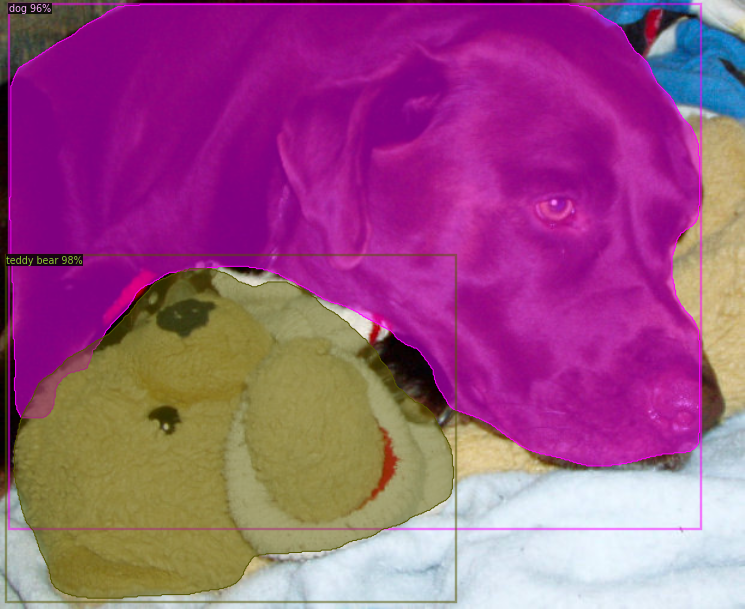

In [16]:
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from google.colab.patches import cv2_imshow


im = cv2.imread(pred_image)

v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get("coco_2017_train"),
               scale=1.2,
)
v = v.draw_instance_predictions(predictions["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## Deploy remote endpoint

To process inference data when we are sending it over internet, we need to have two customer ser/deser methods.

In [ ]:
from sagemaker.pytorch import PyTorchModel, PyTorch, PyTorchPredictor
from sagemaker.estimator import Estimator, Model

remote_model = PyTorchModel(
                     name = "d2-service-v3",
                     model_data="s3://sagemaker-us-east-2-553020858742/detectron2-model/R101-FPN-v2.tar.gz", # from training job
                     role=role,
                     sagemaker_session = sess,
                     entry_point="predict_coco.py", source_dir="container_serving",
                     framework_version="1.4", py_version="3.6",
                     image=image)

In [ ]:
endpoint_name = f"{container_serving}-{tag}"

remote_predictor = remote_model.deploy(
                         instance_type='ml.p3.16xlarge',
                         initial_instance_count=1,
                         update_endpoint = True, # comment or False if endpoint doesns't exist
                         endpoint_name=endpoint_name, # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}],
                         wait=False
                         )

In [ ]:
# Let's get another image to predict
! wget http://farm6.staticflickr.com/5290/5382403037_73709768a2_z.jpg

In [ ]:
import boto3
from io import BytesIO

pred_image = '5382403037_73709768a2_z.jpg'

client = boto3.client('sagemaker-runtime')
accept_type = "json" # "json" or "detectron2". Won't impact predictions, just different deserialization pipelines.
content_type = 'image/jpeg'
headers = {'content-type': content_type}
payload = open(pred_image, 'rb')
endpoint_name = "d2-service-v4"
device = "cuda:0"

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType=content_type,
    Accept = accept_type
)

if accept_type=="json":
    predictions = json_to_d2(response['Body'].read(), device)
elif accept_type=="detectron2":
    print(response['Body'].read())
    stream = BytesIO(response['Body'].read())
    predictions = pickle.loads(stream.read())


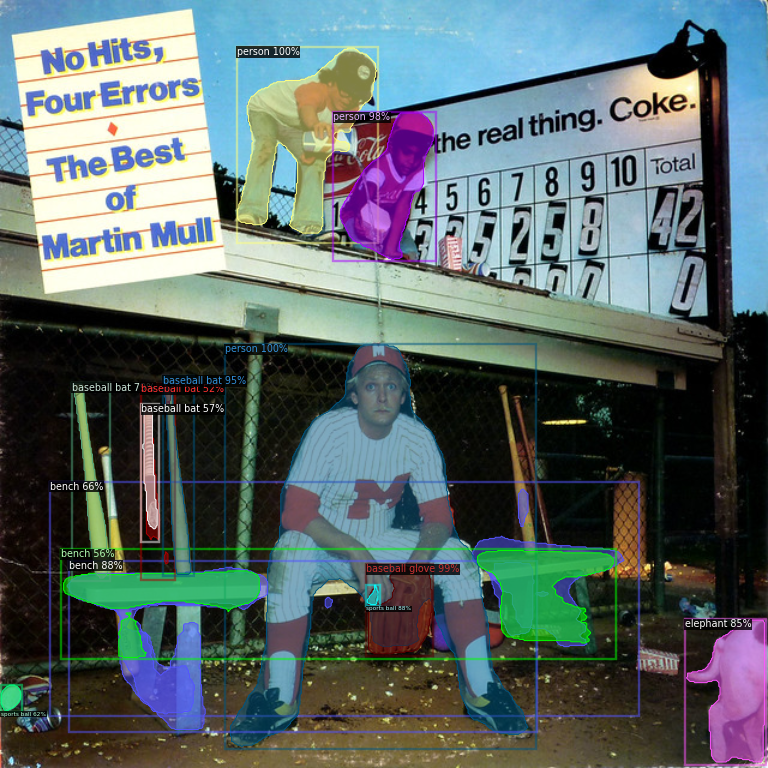

In [83]:
from detectron2.utils.visualizer import ColorMode, Visualizer
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread(pred_image)

v = Visualizer(im[:, :, ::-1],
               metadata=MetadataCatalog.get("coco_2017_train"),
               scale=1.2,
)
v = v.draw_instance_predictions(predictions["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
predictor.delete_endpoint()